In [26]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import matplotlib.pyplot as plt

In [5]:
# load iris dataset
data = load_iris()
X = data.data
y = data.target

# data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)
print(X_train[:5])
print(y_train[:5])

[[-1.50652052  1.24920112 -1.56757623 -1.3154443 ]
 [-0.17367395  3.09077525 -1.2833891  -1.05217993]
 [ 1.03800476  0.09821729  0.36489628  0.26414192]
 [-1.26418478  0.78880759 -1.22655167 -1.3154443 ]
 [-1.74885626  0.32841405 -1.39706395 -1.3154443 ]]
[0 0 1 0 0]


In [6]:
# define model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)  # three tyes

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [7]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# training
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

In [9]:
# evaluate in the testing dataset
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"accuracy: {accuracy}")

accuracy: 0.9666666666666667


MLP(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [46]:
# calculate the mean, variance and covariance from the iris dataset
m = X_train.shape[0]
n = X_train.shape[1]
yT = y_train.reshape(-1, 1)
orgIris = np.concatenate((X_train, yT), axis=1)
meanIris = [np.mean(orgIris[:,i]) for i in range(0,n+1)]
print(meanIris)
varsIris = [np.var(orgIris[:,i]) for i in range(0,n+1)]
print(varsIris)
covIris = np.cov(orgIris.T)
print(covIris)

[-0.041399022401582365, 0.009975193204539552, -0.017809060432930533, -0.02106114948644904, 0.9916666666666667]
[0.9880742157550448, 1.059972939491857, 0.9837246321940026, 0.9724315370463494, 0.658263888888889]
[[ 0.99637736 -0.11034707  0.85715874  0.79223006  0.62120595]
 [-0.11034707  1.06888028 -0.44492955 -0.37829946 -0.37408587]
 [ 0.85715874 -0.44492955  0.99199123  0.94937124  0.76910432]
 [ 0.79223006 -0.37829946  0.94937124  0.98060323  0.76748569]
 [ 0.62120595 -0.37408587  0.76910432  0.76748569  0.66379552]]


In [58]:
# using PCA to generate synthetic dataset
l, v = np.linalg.eig(covIris)
# calculate the largest three eigenvalues and transformation matrix
e=3 # 3 eigenvalues
max_index = np.argpartition(l,-e)[-e:]
matrix = np.zeros((n+1,e))
for i in range(e-1,-1,-1):
    matrix[:,e-1-i] = v[:,max_index[i]]

# calculate new mean and variance
nmean = np.dot(meanIris, matrix)
nvar = np.dot(varsIris, matrix*matrix)
k = np.sqrt(nvar)

# sample for the new features
s0 = np.random.normal(nmean[0], k[0], 10)
s1 = np.random.normal(nmean[1], k[1], 10)
s2 = np.random.normal(nmean[2], k[2], 10)

# make Cartesian production
A = list(itertools.product(s0,s1,s2))

# convert them back
synIris = np.dot(A, matrix.T)

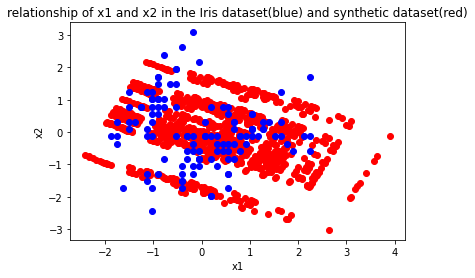

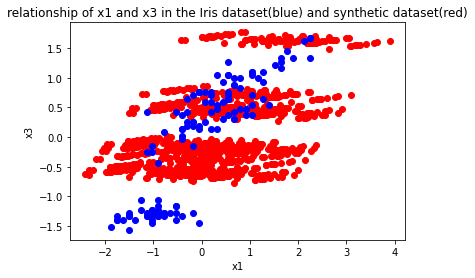

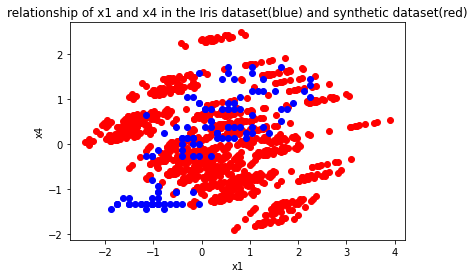

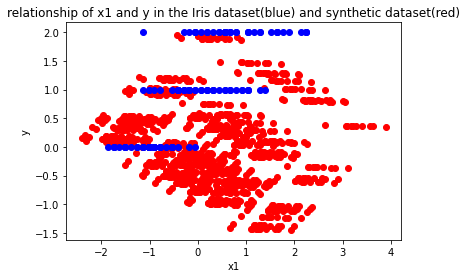

In [59]:
plt.plot(synIris[:,0], synIris[:,1], 'ro')
plt.plot(X_train[:,0], X_train[:,1], 'bo')
plt.title("relationship of x1 and x2 in the Iris dataset(blue) and synthetic dataset(red)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

plt.plot(synIris[:,0], synIris[:,2], 'ro')
plt.plot(X_train[:,0], X_train[:,2], 'bo')
plt.title("relationship of x1 and x3 in the Iris dataset(blue) and synthetic dataset(red)")
plt.xlabel("x1")
plt.ylabel("x3")
plt.show()

plt.plot(synIris[:,0], synIris[:,3], 'ro')
plt.plot(X_train[:,0], X_train[:,3], 'bo')
plt.title("relationship of x1 and x4 in the Iris dataset(blue) and synthetic dataset(red)")
plt.xlabel("x1")
plt.ylabel("x4")
plt.show()

plt.plot(synIris[:,0], synIris[:,4], 'ro')
plt.plot(X_train[:,0], y_train, 'bo')
plt.title("relationship of x1 and y in the Iris dataset(blue) and synthetic dataset(red)")
plt.xlabel("x1")
plt.ylabel("y")
plt.show()

In [60]:
# evaluate the synthetic dataset using the model
syn_X_tensor = torch.tensor(synIris[:,0:n], dtype=torch.float32)
syn_y_tensor = torch.tensor(synIris[:,n], dtype=torch.int64)
with torch.no_grad():
    model.eval()
    test_outputs = model(syn_X_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == syn_y_tensor).sum().item() / len(syn_y_tensor)
    print(f"accuracy of using the synthetic dataset as test data: {accuracy}")

accuracy of using the synthetic dataset as test data: 0.305


#### One possible reasons for low accuracy:
The predicted labels are discrete. I just apply PCA for y and consider it as continuous variable, but the categories are discrete.

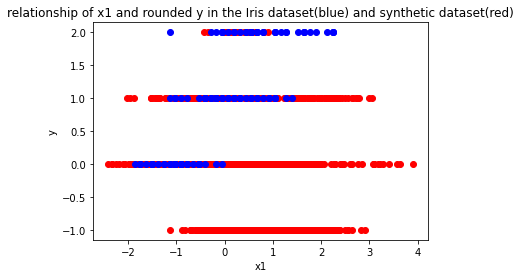

accuracy of using the synthetic dataset as test data: 0.231


In [78]:
# try to round the values of y in the synthetic dataset
y2 = np.round(synIris[:,n])
plt.plot(synIris[:,0], y2, 'ro')
plt.plot(X_train[:,0], y_train, 'bo')
plt.title("relationship of x1 and rounded y in the Iris dataset(blue) and synthetic dataset(red)")
plt.xlabel("x1")
plt.ylabel("y")
plt.show()

syn_y_tensor2 = torch.tensor(y2, dtype=torch.int64)
# test it again
with torch.no_grad():
    model.eval()
    test_outputs = model(syn_X_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == syn_y_tensor2).sum().item() / len(syn_y_tensor2)
    print(f"accuracy of using the synthetic dataset as test data: {accuracy}")

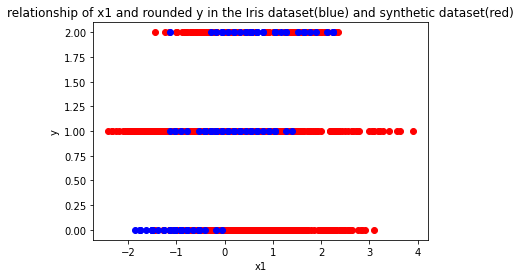

accuracy of using the rounded synthetic dataset as test data: 0.4946581196581197


In [79]:
# try to round up y
y3 = np.ceil(synIris[:,n])
# filter the datapoints whose rounded y is out of boundary
filtered = synIris[y3[:] != -1]
filtered_X = filtered[:,:n]
filtered_y = np.ceil(filtered[:,n])

plt.plot(filtered_X[:,0], filtered_y, 'ro')
plt.plot(X_train[:,0], y_train, 'bo')
plt.title("relationship of x1 and rounded y in the Iris dataset(blue) and synthetic dataset(red)")
plt.xlabel("x1")
plt.ylabel("y")
plt.show()

# and test it again
syn_X_tensor4 = torch.tensor(filtered_X[:,0:n], dtype=torch.float32)
syn_y_tensor4 = torch.tensor(filtered_y, dtype=torch.int64)
with torch.no_grad():
    model.eval()
    test_outputs = model(syn_X_tensor4)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == syn_y_tensor4).sum().item() / len(syn_y_tensor4)
    print(f"accuracy of using the rounded synthetic dataset as test data: {accuracy}")

#### Conclusion:
- Generating datasets using PCA is feasible for different distributions. Even though these datasets(NormalDataset, ExpDataset, and IrisDataset) have different distributions, I use normal distribution to generate samples for all of them. And all the generated datasets can be close to the original ones as can be seen in the figures.
- However, some conditions need to be met. The data should be continuous. Otherwise, we need to do some operations(like rounding) or use othe methods to generate synthetic dataset.
- The generated dataset is not always close to the original dataset. One reason is that the sampling is random. If the numbers of samples are not large(e.g. for iris dataset, I use 10 samples per feature), it is possible that the result is not good.
- Choosing the number of features may be important. Preserving more features can generate better result(e.g. choosing 3 features in ExpDataset leads to better result). But if there are a lot of attributes in the original dataset, choosing less features may reduce the generation time.